In [86]:
import numpy as np

print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) +
                                      0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learns first dependency:  ",
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
- learns neither dependency: 0.661563238158
- learns first dependency:   0.519166699707
- learns both dependencies:  0.454454367449


In [96]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [97]:
# Global config variables
num_steps = 20 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 1024
learning_rate = 0.1

In [98]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [99]:
tf.reset_default_graph()
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)



In [100]:
""""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell.
"""
with tf.variable_scope('rnn_cell'):
    W_h = tf.get_variable('W_h', [num_classes + state_size, state_size]) # Concatenating W_hh and W_xh for efficiency
    b_h = tf.get_variable('b_h', [state_size], initializer=tf.constant_initializer(0.0))


def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W_h = tf.get_variable('W_h', [num_classes + state_size, state_size])
        b_h = tf.get_variable('b_h', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], axis=1), W_h) + b_h)

In [101]:
"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [102]:
"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

#logits and predictions
with tf.variable_scope('softmax'):
    W_y = tf.get_variable('W_y', [state_size, num_classes])
    b_y = tf.get_variable('b_y', [num_classes], initializer=tf.constant_initializer(0.0))
    
logits = [tf.matmul(rnn_output, W_y) + b_y for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

#losses and train_step
losses = []
for logit, label in zip(logits, y_as_list):
    losses.append(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit))

total_loss = tf.reduce_mean(losses)
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [103]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        epoch_training_losses = np.zeros(num_epochs)
        
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            training_losses = []
            
            print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              optimizer],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                
                if step % 100 == 0 and step > 0:
                    print("Average loss at step", step,
                              ":", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
                    
            
            epoch_training_losses[idx] = np.mean(np.array(training_losses))
            print("Epoch training loss :", epoch_training_losses[idx])

    return epoch_training_losses


EPOCH 0
Average loss at step 100 : 5.23334505439
Average loss at step 200 : 1.84934262514
Average loss at step 300 : 1.33609352469
Average loss at step 400 : 1.1687880075
Epoch training loss : 2.39689230293

EPOCH 1
Average loss at step 100 : 0.900888188481
Average loss at step 200 : 0.823753510118
Average loss at step 300 : 0.79296028316
Average loss at step 400 : 0.775264136195
Epoch training loss : 0.823216529489

EPOCH 2
Average loss at step 100 : 0.718144524097
Average loss at step 200 : 0.633815484047
Average loss at step 300 : 0.577784819007
Average loss at step 400 : 0.570665014386
Epoch training loss : 0.625102460384

EPOCH 3
Average loss at step 100 : 0.556012340486
Average loss at step 200 : 0.542415933907
Average loss at step 300 : 0.5315213871
Average loss at step 400 : 0.516890492439
Epoch training loss : 0.536710038483

EPOCH 4
Average loss at step 100 : 0.503349284828
Average loss at step 200 : 0.487604597211
Average loss at step 300 : 0.482148230076
Average loss at st

Average loss at step 300 : 0.455855282545
Average loss at step 400 : 0.45498953402
Epoch training loss : 0.457661576644

EPOCH 39
Average loss at step 100 : 0.46190253824
Average loss at step 200 : 0.455339223742
Average loss at step 300 : 0.455311035216
Average loss at step 400 : 0.455494381785
Epoch training loss : 0.457011794746

EPOCH 40
Average loss at step 100 : 0.460901653469
Average loss at step 200 : 0.453977181911
Average loss at step 300 : 0.454856483936
Average loss at step 400 : 0.455642648041
Epoch training loss : 0.456344491839

EPOCH 41
Average loss at step 100 : 0.461754957736
Average loss at step 200 : 0.455122143328
Average loss at step 300 : 0.454703035355
Average loss at step 400 : 0.455918884277
Epoch training loss : 0.456874755174

EPOCH 42
Average loss at step 100 : 0.460518634021
Average loss at step 200 : 0.455539596677
Average loss at step 300 : 0.456188410521
Average loss at step 400 : 0.455708051622
Epoch training loss : 0.45698867321

EPOCH 43
Average loss

Epoch training loss : 0.456322555393

EPOCH 77
Average loss at step 100 : 0.46117611438
Average loss at step 200 : 0.454446790516
Average loss at step 300 : 0.454379842281
Average loss at step 400 : 0.456502313018
Epoch training loss : 0.456626265049

EPOCH 78
Average loss at step 100 : 0.462541861534
Average loss at step 200 : 0.455571972132
Average loss at step 300 : 0.453335564435
Average loss at step 400 : 0.455470516384
Epoch training loss : 0.456729978621

EPOCH 79
Average loss at step 100 : 0.460056195855
Average loss at step 200 : 0.455051579475
Average loss at step 300 : 0.454628020227
Average loss at step 400 : 0.456688261628
Epoch training loss : 0.456606014296

EPOCH 80
Average loss at step 100 : 0.460287311077
Average loss at step 200 : 0.455304474831
Average loss at step 300 : 0.454682426155
Average loss at step 400 : 0.456355243027
Epoch training loss : 0.456657363772

EPOCH 81
Average loss at step 100 : 0.460859349966
Average loss at step 200 : 0.454837644696
Average lo

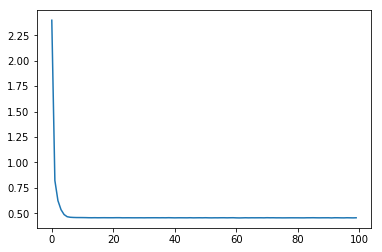

In [104]:
training_losses = train_network(100,num_steps, state_size)
plt.plot(training_losses)